In [1]:
%run cleanData.ipynb
%run cleanData_test.ipynb

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

In [3]:
#Convert data into float to be used in our algorithm

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df_train=clean_dataset(df_train)
df_test =clean_dataset(df_test)

In [4]:
#We are using 80-20 split for train-test
VALID_SIZE = 0.2
#We also use random state for reproducibility
RANDOM_STATE = 2018

train, valid = train_test_split(df_train, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [5]:
df_train

,age,gender,scentLover,ecoInterest,washDishes,MrPropre,Antikal,Ariel,Dash,pods,...,likesPets,hasPet,daysSinceActivity,nbChildren,magasin,moyenneSurface,superMarket,hyperMarket,drive,hardDiscount
0,0.077922,1.0,0.000000,0.387479,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.9,1.0,0.234694,0.2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.636364,1.0,0.378258,0.666667,1.0,1.0,1.0,1.0,-1.0,1.0,...,0.3,-1.0,0.014914,0.6,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.350649,1.0,0.000000,0.666667,1.0,-1.0,-1.0,1.0,1.0,-1.0,...,0.9,1.0,0.094976,0.2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.220779,1.0,0.333333,0.333333,-1.0,-1.0,-1.0,1.0,1.0,1.0,...,0.9,1.0,0.259812,0.4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.259740,1.0,0.378258,0.000000,-1.0,1.0,1.0,1.0,1.0,-1.0,...,0.9,1.0,0.116954,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.454545,1.0,0.378258,0.387479,1.0,-1.0,-1.0,-1.0,-1.0,1.0,...,0.9,1.0,0.000785,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
11996,0.324675,1.0,0.333333,0.333333,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.9,1.0,0.124019,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
11997,0.311688,1.0,0.378258,0.666667,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.9,1.0,0.018838,0.6,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
11998,0.272727,-1.0,0.378258,0.387479,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.9,1.0,0.197017,0.2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


First, we define the predictors variables, then the target variable to predict

In [6]:
predictors = ['age',
'gender',
'scentLover',
'ecoInterest',
'MrPropre',
'Antikal',
'Ariel',
'Dash',
'pods',
'powder',
'liquid',
'electricToothbrush',
'likesPets',
'hasPet',
'daysSinceActivity',
'nbChildren',
'magasin',
'moyenneSurface',
'superMarket',
'hyperMarket',
'drive',
'hardDiscount']
target = 'washDishes'

In [7]:
train_X = train[predictors]
train_Y = train[target].values
valid_X = valid[predictors]
valid_Y = valid[target].values


Implementation of Stochastic Gradient Descent Algorithm

In [8]:

clf = SVC()


In [9]:
#Training of the model
clf.fit(train_X, train_Y)

SVC()

In [10]:
#Validation of the model on the remaining 20% of the training set
preds = clf.predict(valid_X)


In [11]:
preds.shape

(2323,)

In [12]:
#In order to better understand the importance of each variable, we want to plot the features importance.
def plot_feature_importance():
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (7,4))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

In [14]:
#plot_feature_importance()

'daysSinceActivity' and 'Age' are the two most important features in the prediction.

Evaluation of our model

In [15]:
clf.score(train_X, train_Y)
acc = round(clf.score(train_X, train_Y) * 100, 2)
print("SVC accuracy (train set):", acc)

SGD accuracy (train set): 62.45


In [16]:

clf.score(valid_X, valid_Y)
acc = round(clf.score(valid_X, valid_Y) * 100, 2)
print("SVC accuracy (validation set):", acc)

SGD accuracy (validation set): 61.43


In [17]:
print(metrics.classification_report(valid_Y, preds, target_names=['Hand', 'Auto']))

              precision    recall  f1-score   support

        Hand       0.62      0.95      0.75      1403
        Auto       0.57      0.11      0.18       920

    accuracy                           0.61      2323
   macro avg       0.59      0.53      0.47      2323
weighted avg       0.60      0.61      0.52      2323



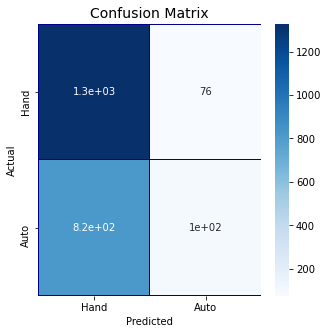

In [18]:
def plot_confusion_matrix():
    cm = pd.crosstab(valid_Y, preds, rownames=['Actual'], colnames=['Predicted'])
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['Hand', 'Auto'],
                yticklabels=['Hand', 'Auto'],
                annot=True,ax=ax1,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()

plot_confusion_matrix()

Let's initialize the GradientSearchCV parameters for optimization. We will set only few parameters, as following:

n_estimators: number of trees in the foreset;

max_features: max number of features considered for splitting a node;

max_depth: max number of levels in each decision tree;

min_samples_split: min number of data points placed in a node before the node is split;

min_samples_leaf: min number of data points allowed in a leaf node.

In [26]:
#Finding best parameters for our SVC model

parameters = {
    'C': [0.8,1.3],
    'kernel':['linear', 'rbf'],
    'gamma' :[0.8, 1.3]
}

#We initialize GridSearchCV with the classifier, the set of parameters, number of folds and also the level of verbose for printing out progress.

grid_svc = GridSearchCV(clf, parameters, scoring='accuracy', cv=10)
grid_svc.fit(train_X, train_Y)

print('Best scores:',grid_svc.best_score_)
print('Best params:',grid_svc.best_params_)




Best scores: 0.6064173796444081
Best params: {'C': 0.8, 'gamma': 1.3, 'kernel': 'rbf'}


In [28]:
#Let's run our SVC again with the best parameters.
svc2 = SVC(C=0.8, gamma=1.3, kernel= 'rbf')
svc2.fit(train_X, train_Y)
pred_svc2 = svc2.predict(valid_X)
print(metrics.classification_report(valid_Y, pred_svc2))

              precision    recall  f1-score   support

        -1.0       0.62      0.87      0.72      1403
         1.0       0.49      0.19      0.28       920

    accuracy                           0.60      2323
   macro avg       0.56      0.53      0.50      2323
weighted avg       0.57      0.60      0.55      2323



In [29]:
svc2.score(valid_X, valid_Y)
acc = round(svc2.score(valid_X, valid_Y) * 100, 2)
print("SVC accuracy optimized (validation set):", acc)

SVC accuracy optimized (validation set): 60.18


In [30]:
print(metrics.classification_report(valid_Y, preds, target_names=['Hand', 'Auto']))

              precision    recall  f1-score   support

        Hand       0.62      0.95      0.75      1403
        Auto       0.57      0.11      0.18       920

    accuracy                           0.61      2323
   macro avg       0.59      0.53      0.47      2323
weighted avg       0.60      0.61      0.52      2323



Use of our model in the test dataset to submit on Kaggle

In [32]:
prediction_test = svc2.predict(df_test)

In [33]:
prediction_test[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

#As we have drop the userId column, we have to add it again next to the predicted values for the column "washDishes" so we get the userId again from the data set test.
df_test_full = pd.read_csv(r"DS_CentraleSupelec_ST42021/DS_CentraleSupelec_test.csv")

In [34]:
result_prediction = pd.DataFrame(prediction_test, columns =['WashDishes'])

In [35]:
result_prediction['WashDishes']

0      -1.0
1      -1.0
2      -1.0
3      -1.0
4      -1.0
       ... 
3995    1.0
3996   -1.0
3997   -1.0
3998   -1.0
3999   -1.0
Name: WashDishes, Length: 4000, dtype: float64

In [36]:
submit = pd.concat([df_test_full['userId'],result_prediction['WashDishes']], axis=1)
submit.shape

NameError: name 'df_test_full' is not defined

In [ ]:
submit

#Formatting the submit data to fit the submission format expected by Kaggle.
submit.rename(columns={"washDishes": "WashDishes"})

submit['WashDishes'] = submit['WashDishes'].apply(lambda e: 'Auto' if e == 1 else 'Hand')
submit

In [ ]:
submit.to_csv('./DS_CentraleSupelec_ST42021/submit_catboost.csv', index=False)  